In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as st
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler

from matplotlib.dates import DateFormatter

In [2]:
np.random.seed(72)

# Data Importation

In [3]:
start_date = "2021-10-02"
end_date = "2023-11-08"

# Create a boolean mask based on the date range
dates = lambda df : (df.index >= start_date) & (df.index <= end_date)

In [4]:
# Target variable (stationary)
passengers_df = pd.read_csv("passengers_stationary.csv").set_index("datetime")
passengers_df.index = pd.to_datetime(passengers_df.index, format = "ISO8601")

passengers = passengers_df[["total"]].dropna()

# Restrict to relevant dates
passengers = passengers[dates(passengers)]

# Some data is missing as log could not be applied to 0
passengers = passengers.resample("H").sum().fillna(0)

# Features
features = pd.read_csv("standardized_features.csv").set_index("datetime")
features.index = pd.to_datetime(features.index, format = "ISO8601")

# Only use the features that were not dropped by Lasso (see Notebook LSTM)
features = features[['Traffic','Sunshine','School Holidays ZH','School Holidays TG','School Holidays AG','rain',
                     'Weekday_Friday','Weekday_Saturday','Weekday_Sunday',
                     'Weekday_Thursday','Weekday_Tuesday','stores_closed_on_that_day']]

# Split into train and test split

In [5]:
# Split into training and test split
n_splits = 2
tscv = TimeSeriesSplit(n_splits)

y = passengers[["total"]].copy()
X = features.copy()

for train_index, test_index in tscv.split(passengers):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [6]:
# Standardize the Data to obtain better results
# Only standardize non binary data
non_binary = ['Traffic', 'Sunshine']
binary = ['School Holidays ZH', 'School Holidays TG',
       'School Holidays AG', 'rain', 'Weekday_Friday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'stores_closed_on_that_day']
X_train_nb = X_train[non_binary]
X_test_nb = X_test[non_binary]
X_train_b = X_train[binary]
X_test_b = X_test[binary]

# Standardize data
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_nb), columns = X_train_nb.columns).set_index(X_train_nb.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_nb), columns = X_test_nb.columns).set_index(X_test_nb.index)

# Concatenate with dummy variables
X_train_scaled = pd.merge(X_train_scaled, X_train_b, how = "left", left_index = True, right_index = True)
X_test_scaled = pd.merge(X_test_scaled, X_test_b, how = "left", left_index = True, right_index = True)

# Building the Model

### Finding the optimal pruning parameter

In [7]:
# Create a decision tree regressor
clf = DecisionTreeRegressor()

# Create a range of ccp_alpha values to test
ccp_alphas = np.logspace(-4, 0, 200)

# TimeSeriesSplit for time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)  

# Store the cross-validation scores for each ccp_alpha value
scores = []
scores_std = []

for alpha in ccp_alphas:
    clf.set_params(ccp_alpha=alpha)
    current_scores = cross_val_score(clf, X_train_scaled, y_train, cv=tscv, scoring = "neg_mean_squared_error")
    scores.append(-current_scores.mean())
    scores_std.append(current_scores.std())

# Find the optimal ccp_alpha value
best_alpha = ccp_alphas[np.argmin(scores)]
print("Best alpha:", best_alpha)

Best alpha: 0.004659525668664682


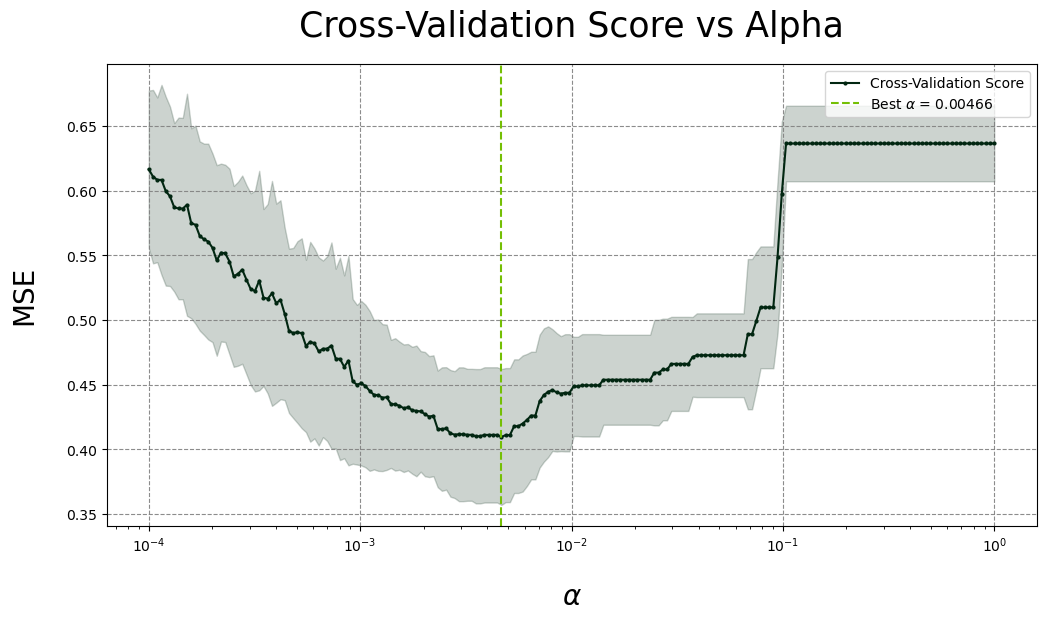

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

# Set the custom color palette
custom_colors = ['#012611', '#265902', '#488C03', '#74BF04', '#EBF20C']


ax.plot(ccp_alphas, scores, '-o', label="Cross-Validation Score", markersize=2, color = custom_colors[0])
ax.fill_between(ccp_alphas, np.array(scores) - np.array(scores_std),
                np.array(scores) + np.array(scores_std), alpha=0.2, color = custom_colors[-5])
ax.grid(color="grey", linestyle = "dashed", alpha = 0.9)
# Plot best alpha
ax.axvline(best_alpha, ls="--", color = custom_colors[-2], label=f"Best $\\alpha$ = {best_alpha:.5f}")
ax.legend()

ax.set_xlabel("$\\alpha$", labelpad = 20, fontsize = 20)
ax.set_ylabel("MSE", labelpad = 20, fontsize = 20)
ax.set_xscale("log")
ax.set_title("Cross-Validation Score vs Alpha", fontsize = 25, pad = 20)


plt.savefig("decison_tree_ccp.png")
plt.show()


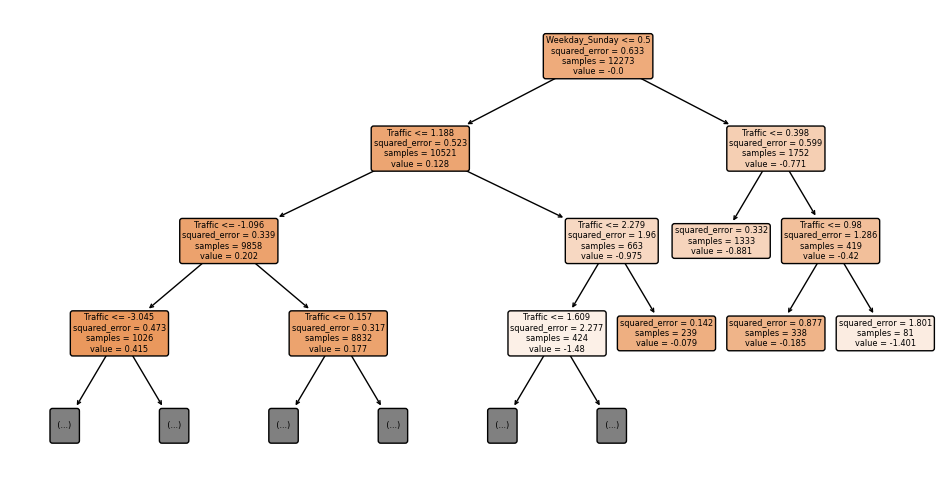

<Figure size 1200x600 with 0 Axes>

In [29]:
# Create the decision tree classifier with the best alpha
clf = DecisionTreeRegressor(ccp_alpha = best_alpha).fit(X_train_scaled, y_train)
fig, ax = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
# Plot the decision tree
plt.figure(figsize=(12, 6))
plot_tree(clf, filled=True, feature_names=X_train_scaled.columns, max_depth = 3, rounded = True, ax=ax)
fig.savefig("decisons.png");

# Generate a Prediction

### Necessary functions

In [30]:
# Generate predictions (not yet converted back to normal data)
def generate_prediction(model, X):
    # Change to best model
    predicted_scaled = pd.DataFrame(model.predict(X), index = X.index)
    predicted_scaled.columns = ["Prediction"]
    return predicted_scaled

In [31]:
# invert differenced value
def inverse_difference(yhat, history = passengers_df, interval=24):
    # Merge the logged actual data and the prediction
    x = pd.merge(history[["log"]], yhat, left_index = True, right_index = True)
    
    # Shift by the number of periods used to remove the seasonality
    x["Shifted"] = x.log.shift(interval)
    # Drop the 24 days for which no previous season available
    x = x.dropna()
    # Show to actual prediction by summing the prediction and the past seasonal value and reversing the log transformation
    x["pred"] = np.exp(x.Prediction+x.Shifted)
    # Show the actual data by reversing the log transformation
    x["actual"] = np.exp(x.log)
    return x

In [32]:
def mse(y_hat, y):
    return np.mean((y_hat - y)**2)

### Predicting the test data

In [33]:
# Showing predictions of test data
predicted_scaled = generate_prediction(clf,X_test_scaled)
pred = inverse_difference(predicted_scaled)

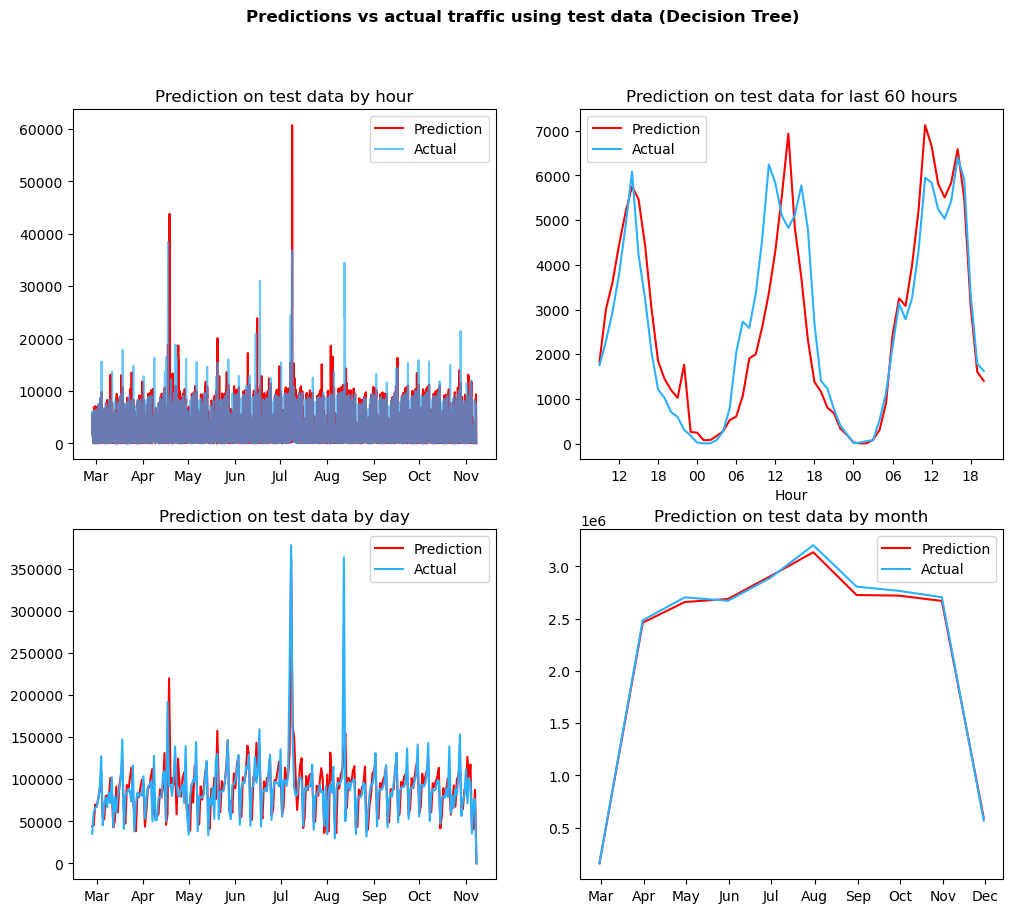

In [34]:
# Plotting predictions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Predictions vs Actual Traffic Using Test Data (Decision Tree)", fontweight="bold", fontsize = 20)
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

# Custom colors
prediction_color = '#74BF04'
actual_color = '#012611'

# Total predictions
axs[0, 0].plot(pred.pred, c=prediction_color, label="Prediction")
axs[0, 0].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[0, 0].plot(pred.actual, c=actual_color, label="Actual", alpha=0.7)
axs[0, 0].set_title("Prediction on Test Data by Hour", )
axs[0, 0].legend()

# Last 60 hours to see whether daily seasonality captured
axs[0, 1].plot(pred.pred.head(60), c=prediction_color, label="Prediction")
axs[0, 1].plot(pred.actual.head(60), c=actual_color, label="Actual")
axs[0, 1].set_title("Prediction on Test Data for Last 60 Hours",)
axs[0, 1].set_xlabel("Hour")
axs[0, 1].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[0, 1].legend()

# By day
axs[1, 0].plot(pred.resample("D").sum().pred, c=prediction_color, label="Prediction")
axs[1, 0].plot(pred.resample("D").sum().actual, c=actual_color, label="Actual")
axs[1, 0].set_title("Prediction on Test Data by Day", )
axs[1, 0].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[1, 0].legend()

# By month
axs[1, 1].plot(pred.resample("M").sum().pred, c=prediction_color, label="Prediction")
axs[1, 1].plot(pred.resample("M").sum().actual, c=actual_color, label="Actual")
axs[1, 1].set_title("Prediction on Test Data by Month")
axs[1, 1].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[1, 1].legend()

# Format x-Axis
date_form_hour = DateFormatter("%b")
date_form_60 = DateFormatter("%H")
axs[0, 0].xaxis.set_major_formatter(date_form_hour)
axs[0, 1].xaxis.set_major_formatter(date_form_60)
axs[1, 1].xaxis.set_major_formatter(date_form_hour)
axs[1, 0].xaxis.set_major_formatter(date_form_hour)
plt.savefig("dt.png")

In [37]:
mse_regressor = mse(pred.pred, pred.actual)
print(f"The MSE of the Decision Tree Regressor is{mse_regressor: 0.2f}")

The MSE of the Decision Tree Regressor is 5651414.36


# Ensemble Method: Random Forest

In [36]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# Define the parameter grid for tuning
param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize Random Forest Regressor
random_f = RandomForestRegressor(random_state=42, max_features ="sqrt")

# Define mean squared error as the scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_f, param_grid=param_grid, scoring=scorer, cv=tscv)

# Fit the model
grid_search.fit(X_train_scaled, y_train.values.ravel())

# Print the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [38]:
# Showing predictions of test data
predicted_scaled_rf = generate_prediction(grid_search,X_test_scaled)
pred_rf = inverse_difference(predicted_scaled_rf)

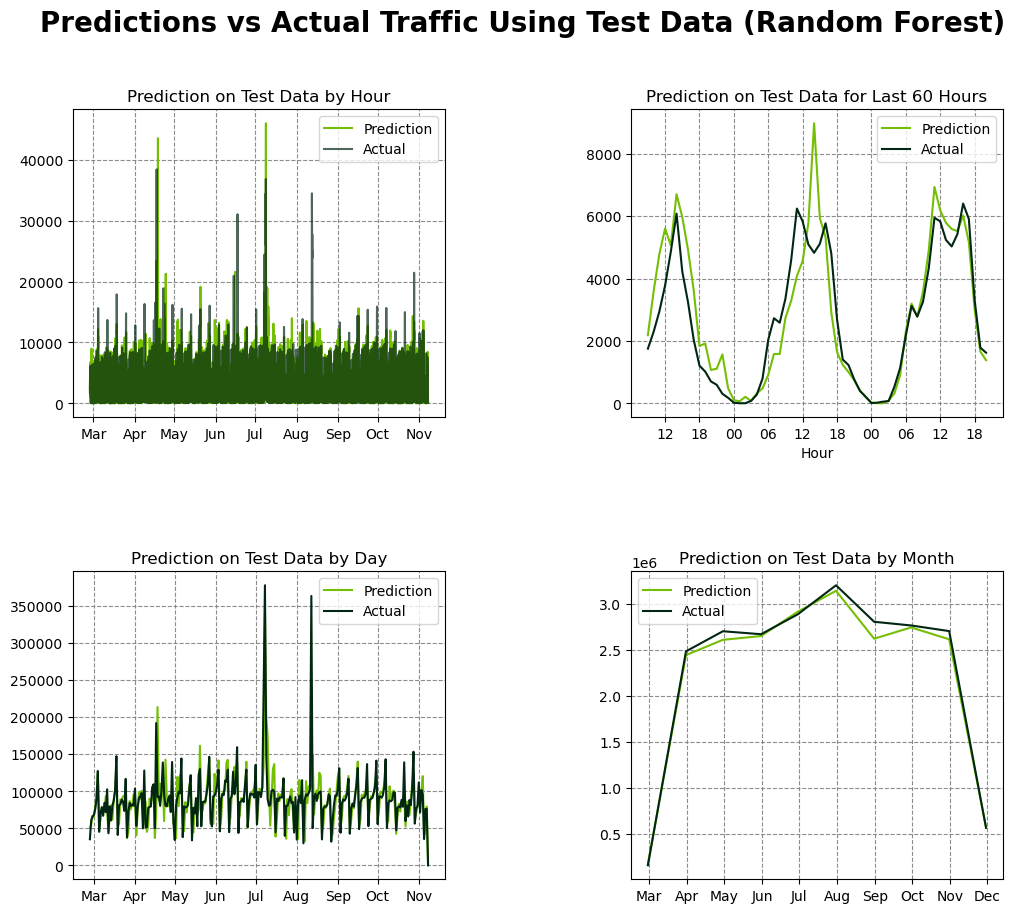

In [39]:
from matplotlib.dates import DateFormatter

# Plotting predictions
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Predictions vs Actual Traffic Using Test Data (Random Forest)", fontweight="bold", fontsize = 20)
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

# Custom colors
prediction_color = '#74BF04'
actual_color = '#012611'

# Total predictions
axs[0, 0].plot(pred_rf.pred, c=prediction_color, label="Prediction")
axs[0, 0].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[0, 0].plot(pred_rf.actual, c=actual_color, label="Actual", alpha=0.7)
axs[0, 0].set_title("Prediction on Test Data by Hour", )
axs[0, 0].legend()

# Last 60 hours to see whether daily seasonality captured
axs[0, 1].plot(pred_rf.pred.head(60), c=prediction_color, label="Prediction")
axs[0, 1].plot(pred_rf.actual.head(60), c=actual_color, label="Actual")
axs[0, 1].set_title("Prediction on Test Data for Last 60 Hours",)
axs[0, 1].set_xlabel("Hour")
axs[0, 1].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[0, 1].legend()

# By day
axs[1, 0].plot(pred_rf.resample("D").sum().pred, c=prediction_color, label="Prediction")
axs[1, 0].plot(pred_rf.resample("D").sum().actual, c=actual_color, label="Actual")
axs[1, 0].set_title("Prediction on Test Data by Day", )
axs[1, 0].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[1, 0].legend()

# By month
axs[1, 1].plot(pred_rf.resample("M").sum().pred, c=prediction_color, label="Prediction")
axs[1, 1].plot(pred_rf.resample("M").sum().actual, c=actual_color, label="Actual")
axs[1, 1].set_title("Prediction on Test Data by Month")
axs[1, 1].grid(color="grey", linestyle = "dashed", alpha = 0.9)
axs[1, 1].legend()

# Format x-Axis
date_form_hour = DateFormatter("%b")
date_form_60 = DateFormatter("%H")
axs[0, 0].xaxis.set_major_formatter(date_form_hour)
axs[0, 1].xaxis.set_major_formatter(date_form_60)
axs[1, 1].xaxis.set_major_formatter(date_form_hour)
axs[1, 0].xaxis.set_major_formatter(date_form_hour)
plt.savefig("rf.png")

In [40]:
mse_rf = mse(pred_rf.pred, pred_rf.actual)
print(f"The MSE of the Decision Tree Regressor is{mse_rf: 0.2f}")

The MSE of the Decision Tree Regressor is 5059204.39
